## Installations

In [19]:
!pip install onnxruntime==1.17.0
!pip install --upgrade transformers
!sudo apt-get -y install poppler-utils
!sudo apt -y install tesseract-ocr
! pip install -U langchain openai langchain-chroma langchain-experimental # (newest versions required for multi-modal)
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
!pip install chromadb numpy sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
pip install openai-clip torch torchvision pillow chromadb


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [22]:
!pip install --upgrade setuptools pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Data Preparation

In [23]:
import json
import os

# File paths (update with your actual paths if necessary)
mmqa_data_file = "/kaggle/input/mqa-data/multimodal-qa-data/MMQA_data.jsonl"
mmqa_text_file = "/kaggle/input/mqa-data/multimodal-qa-data/MMQA_texts.jsonl"
image_folder = "/kaggle/input/mqa-data/multimodal-qa-data/filtered-images"

# Load MMQA_data.jsonl
with open(mmqa_data_file, 'r', encoding='utf-8') as f:
    mmqa_data = [json.loads(line.strip()) for line in f]

# Load MMQA_text.jsonl
with open(mmqa_text_file, 'r', encoding='utf-8') as f:
    mmqa_text = {entry['id']: entry['text'] for entry in (json.loads(line.strip()) for line in f)}

# Get list of image filenames
image_files = set(os.listdir(image_folder))

# Prepare the final dataset
final_dataset = []

for entry in mmqa_data:
    qid = entry['qid']
    question = entry['question']
    answers = entry['answers']
   
    # Initialize supporting text and image
    supporting_texts = []
    supporting_images = []
   
    # Iterate over supporting contexts
    for context in entry['supporting_context']:
        doc_id = context['doc_id']
        doc_part = context['doc_part']
       
        if doc_part == "text" and doc_id in mmqa_text:
            supporting_texts.append(mmqa_text[doc_id])
        elif doc_part == "image":
            image_name = f"{doc_id}.jpg"
            if image_name in image_files:
                supporting_images.append(image_name)
   
    # Add to final data
    final_dataset.append({
        "qid": qid,
        "question": question,
        "answers": answers,
        "supporting text": supporting_texts,
        "supporting image": supporting_images
    })

final_data = final_dataset[0:500] # Number of entries in final_dataset = 1089

In [24]:
# For each entry, create pairs of supporting text and images (in form of paths)

text_image_pairs = []
for i in final_data:
    image_value =''
    if (len(i['supporting image'])!=0):
        image_value = "/kaggle/input/mqa-data/multimodal-qa-data/filtered-images/"+ i['supporting image'][0]
    ti_pair = {"text": " ".join(i['supporting text']) , "image_path": image_value }
    text_image_pairs.append(ti_pair)

In [25]:
print(text_image_pairs[0])

{'text': 'Madrid (/məˈdrɪd/, Spanish:\xa0[maˈðɾið], locally\xa0[maˈðɾi(θ)]) is the capital of Spain and the largest municipality in both the Community of Madrid and Spain as a whole. The city has almost 3.166\xa0million inhabitants with a metropolitan area population of approximately 6.5 million. It is the third-largest city in the European Union (EU) after London and Berlin, and its metropolitan area is the third-largest in the EU after those of London and Paris. The municipality itself covers an area of 604.3\xa0km2 (233.3\xa0sq\xa0mi).', 'image_path': '/kaggle/input/mqa-data/multimodal-qa-data/filtered-images/5eb012385a10b00b17dd46029050aea3.jpg'}


## Creating Collection: Example

In [26]:
# #                                                                        Example to understand what the metadata approach followed by us
# # Install required packages
# # !pip install chromadb numpy sentence-transformers

# import chromadb
# from sentence_transformers import SentenceTransformer
# import base64
# import numpy as np
# from PIL import Image
# from IPython.display import Image as IPImage, display  # For inline display of images
# # Initialize ChromaDB client
# client = chromadb.Client()

# # Create or get a collection
# collection_name = "text_image_collection"
# collection = client.get_or_create_collection(name=collection_name)

# # Initialize text embedding model
# model = SentenceTransformer('all-MiniLM-L6-v2')

# # Helper function to encode an image in base64
# def encode_image(image_path):
#     with open(image_path, "rb") as img_file:
#         return base64.b64encode(img_file.read()).decode("utf-8")

# # Helper function to decode a base64 image and save it
# def decode_image(encoded_image, output_path):
#     with open(output_path, "wb") as img_file:
#         img_file.write(base64.b64decode(encoded_image))

# # Example data: text and associated image paths
# data = [
#     {"text": "A cat sitting on a sofa.", "image_path": "/kaggle/input/dataset1/data/cat.jpg"},
#     {"text": "A beautiful sunset by the beach.", "image_path": "/kaggle/input/dataset1/data/sunset.jpg"}
# ]

# # Process data: generate embeddings and encode images
# documents = []
# embeddings = []
# metadatas = []

# for item in data:
#     text = item["text"]
#     image_path = item["image_path"]

#     # Generate text embedding
#     embedding = model.encode(text).tolist()

#     # Encode image
#     encoded_image = encode_image(image_path)

#     # Prepare for insertion
#     documents.append(text)
#     embeddings.append(embedding)
#     metadatas.append({"image_data": encoded_image})

# # Insert data into ChromaDB with unique IDs
# ids = [f"item_{i}" for i in range(len(documents))]  # Generate unique IDs for each document

# collection.add(
#     ids=ids,  # Required IDs
#     documents=documents,
#     embeddings=embeddings,
#     metadatas=metadatas
# )

# print("Data inserted successfully!")

# # Query the collection
# query_text = "A sunset at the beach."
# query_embedding = model.encode(query_text).tolist()

# results = collection.query(
#     query_embeddings=[query_embedding],
#     n_results=1
# )

# # Display query results
# for i, (doc, metadata_list) in enumerate(zip(results["documents"], results["metadatas"])):
#     print(f"Result {i + 1}:")
#     print(f"Text: {doc}")

#     # Each metadata_list contains one dictionary for each result
#     metadata = metadata_list[0]  # Access the first result's metadata

#     # Decode and save the associated image
#     decoded_image_path = f"retrieved_image_{i + 1}.jpg"
#     decode_image(metadata["image_data"], decoded_image_path)
#     print(f"Image saved as: {decoded_image_path}")

#     # Display the image
#     img = Image.open(decoded_image_path)
#     img.show()
#     display(IPImage(decoded_image_path))

## Creating Vector Collection

In [32]:
# Install required packages
# !pip install chromadb numpy sentence-transformers
import io
from io import BytesIO
import chromadb
from sentence_transformers import SentenceTransformer
import base64
from PIL import Image
from IPython.display import Image as IPImage, display  # For inline display of images

# Initialize ChromaDB client
client = chromadb.Client()

# Create or get a collection
collection_name = "text_image_collection"
collection = client.get_or_create_collection(name=collection_name)

# Initialize text embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Helper function to encode an image in base64
def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

# Helper function to decode a base64 image and save it
def decode_image(encoded_image, output_path):
    with open(output_path, "wb") as img_file:
        img_file.write(base64.b64decode(encoded_image))

# Example data: text and associated image paths
# data = [
#     {"text": "A cat sitting on a sofa.", "image_path": "/kaggle/input/dataset1/data/cat.jpg"},
#     {"text": "A beautiful sunset by the beach.", "image_path": "/kaggle/input/dataset1/data/sunset.jpg"},
#     {"text": "A serene mountain landscape.", "image_path": None},  # No image path provided
#     {"text": "A bustling city at night.", "image_path": None} ,
#     {"text": "sun", "image_path": None} # No image path provided
# ]

# Process data: generate embeddings and encode images
documents = []
embeddings = []
metadatas = []
data = text_image_pairs
for item in data:
    text = item["text"]
    image_path = item.get("image_path")  # Use .get() to avoid KeyError

    # Generate text embedding
    embedding = model.encode(text).tolist()

    # Prepare metadata
    metadata = {"text": text}

    if image_path:  # Only encode the image if a path is provided
        encoded_image = encode_image(image_path)
        metadata["image_data"] = encoded_image

    # Add to lists for insertion
    documents.append(text)
    embeddings.append(embedding)
    metadatas.append(metadata)

# Insert data into ChromaDB with unique IDs
ids = [f"item_{i}" for i in range(len(documents))]  # Generate unique IDs for each document

collection.add(
    ids=ids,  # Required IDs
    documents=documents,
    embeddings=embeddings,
    metadatas=metadatas
)

print("Data inserted successfully!")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Data inserted successfully!


## Example Retrieval

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Result 1:
Text: ['Wachet auf, ruft uns die Stimme (Awake, calls the voice to us), BWV 140,[a] also known as Sleepers Wake, is a church cantata by Johann Sebastian Bach, regarded as one of his most mature and popular sacred cantatas. He composed the chorale cantata in Leipzig for the 27th Sunday after Trinity and first performed it on 25 November 1731.']
Image saved as: retrieved_image_1.jpg


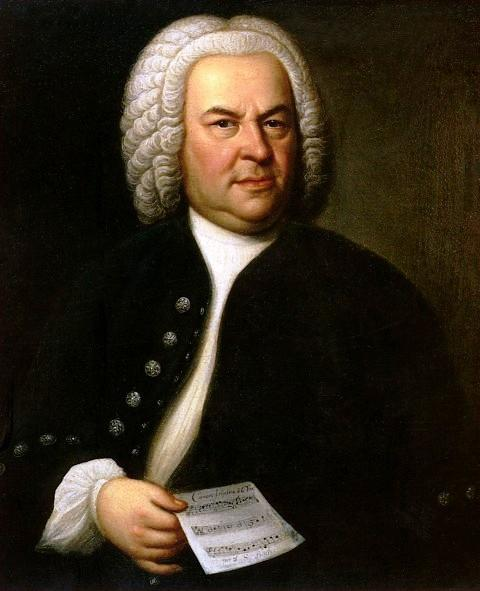

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmplj7w9r4l.PNG'


In [33]:
# Query the collection
query_text = "What's the coat color of the writer of song for wachet auf (sleepers awake) and chorale text?"
query_embedding = model.encode(query_text).tolist()

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=1
)

# Display query results
formatted_texts =''
image  =0
for i, (doc, metadata_list) in enumerate(zip(results["documents"], results["metadatas"])):
    print(f"Result {i + 1}:")
    print(f"Text: {doc}")
    formatted_texts = "\n".join(doc)
    
    for metadata in metadata_list:
        # Decode and save the associated image if it exists
        if "image_data" in metadata:
            decoded_image_path = f"retrieved_image_{i + 1}.jpg"
            decode_image(metadata["image_data"], decoded_image_path)
            print(f"Image saved as: {decoded_image_path}")


            image_data = base64.b64decode(metadata["image_data"])
            image = Image.open(BytesIO(image_data))
            
            # Display the image
            img = Image.open(decoded_image_path)
            img.show()
            display(IPImage(decoded_image_path))
            
        else:
            print("No image associated with this result.")

## Generation

In [29]:
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('<insert-token-here>')"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpl0ewhlbh.PNG'


In [34]:
import requests
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id = "meta-llama/Llama-3.2-11B-Vision"

llm_model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## RAG: Example-1

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Result 1:
Text: ['Wachet auf, ruft uns die Stimme (Awake, calls the voice to us), BWV 140,[a] also known as Sleepers Wake, is a church cantata by Johann Sebastian Bach, regarded as one of his most mature and popular sacred cantatas. He composed the chorale cantata in Leipzig for the 27th Sunday after Trinity and first performed it on 25 November 1731.']
Image saved as: retrieved_image_1.jpg


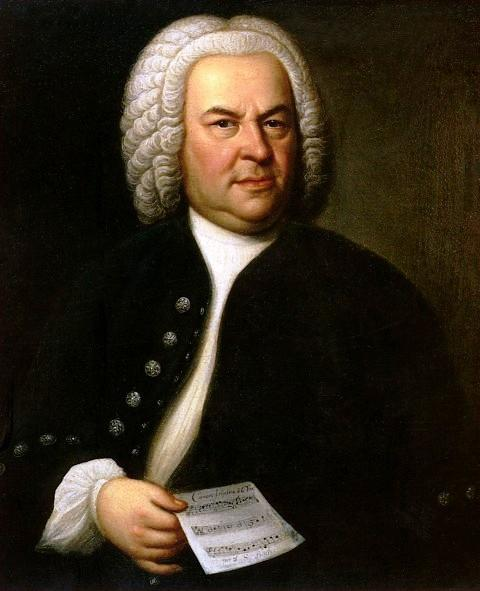

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpp8sjigwx.PNG'


In [95]:
# Query the collection
query_text = "What's the coat color of the writer of song for wachet auf (sleepers awake) and chorale text?"
query_embedding = model.encode(query_text).tolist()

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=1
)

# Display query results
formatted_texts =''
image  =0
for i, (doc, metadata_list) in enumerate(zip(results["documents"], results["metadatas"])):
    print(f"Result {i + 1}:")
    print(f"Text: {doc}")
    formatted_texts = "\n".join(doc)
    
    for metadata in metadata_list:
        # Decode and save the associated image if it exists
        if "image_data" in metadata:
            decoded_image_path = f"retrieved_image_{i + 1}.jpg"
            decode_image(metadata["image_data"], decoded_image_path)
            print(f"Image saved as: {decoded_image_path}")

            # image_data = base64.b64decode(metadata["image_data"])
            # image = Image.open(BytesIO(image_data))
            
            # Display the image
            image = Image.open(decoded_image_path)
            image.show()
            display(IPImage(decoded_image_path))
            
        else:
            print("No image associated with this result.")

In [79]:
sys_prompt = "You are an advanced assistant capable of analyzing both textual and visual data. You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively. You can assume that the image provided is that of the objects or people mentioned in the text. Try to give names as answer. Do not ask for clarifications abou who or what is in the image, it is given in the text, thus, just give your best answer. Example question:  Supporting image: An image will be provided. Supporting Text: Color of Empire State Building is grey. Question: What is the color of the Empire State Building? Example answer: grey"
prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>" + sys_prompt + "<|eot_id|><|start_header_id|>user<|end_header_id|> <|image|> Supporting Text: " + formatted_texts + "Question: " + query_text + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

inputs = processor(image, prompt, return_tensors="pt").to(llm_model.device)
output = llm_model.generate(**inputs, max_new_tokens=35, temperature= 1.4,top_k= 15)
print(processor.decode(output[0]))

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `15` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmplrn5na27.PNG'


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>You are an advanced assistant capable of analyzing both textual and visual data. You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively. You can assume that the image provided is that of the objects or people mentioned in the text. Try to give names as answer. Do not ask for clarifications abou who or what is in the image, it is given in the text, thus, just give your best answer. Example question:  Supporting image: An image will be provided. Supporting Text: Color of Empire State Building is grey. Question: What is the color of the Empire State Building? Example answer: grey<|eot_id|><|start_header_id|>user<|end_header_id|> <|image|> Supporting Text: Wachet auf, ruft uns die Stimme (Awake, calls the voice to us), BWV 140,[a] also known as Sleepers Wake, is a church cantata by Johann Sebastian Bach, regarded as o

In [96]:
sys_prompt = '''
You are an advanced AI model, whise task is to answer the question asked in the prompt concisely, in one to three words.
You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively.
Answer to the best of your ability, in a single go.
'''
prompt = f'''
<|begin_of_text|>\
<|start_header_id|>system<|end_header_id|>\
{sys_prompt}\
<|eot_id|>\
<|start_header_id|>user<|end_header_id|>\
<|image|> Supporting Text: {formatted_texts} \
Question: {query_text} \
<|eot_id|>\
<|start_header_id|>assistant<|end_header_id|>
'''

inputs = processor(image, prompt, return_tensors="pt").to(llm_model.device)
output = llm_model.generate(**inputs, max_new_tokens=35, temperature= 1.4,top_k= 15)
print(processor.decode(output[0]))

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `15` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


<|begin_of_text|>
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an advanced AI model, whise task is to answer the question asked in the prompt concisely, in one to three words.
You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively.
Answer to the best of your ability, in a single go.
<|eot_id|><|start_header_id|>user<|end_header_id|><|image|> Supporting Text: Wachet auf, ruft uns die Stimme (Awake, calls the voice to us), BWV 140,[a] also known as Sleepers Wake, is a church cantata by Johann Sebastian Bach, regarded as one of his most mature and popular sacred cantatas. He composed the chorale cantata in Leipzig for the 27th Sunday after Trinity and first performed it on 25 November 1731. Question: What's the coat color of the writer of song for wachet auf (sleepers awake) and chorale text? <|eot_id|><|start_header_id|>assistant<|end_header_id|>
I'm not able to provi

## RAG: Example-2

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Result 1:
Text: ['The online café phenomenon in the United States was started in July 1991 by Wayne Gregori in San Francisco when he began SFnet Coffeehouse Network. Gregori designed, built and installed 25 coin-operated computer terminals in coffeehouses throughout the San Francisco Bay Area. The café terminals dialed into a 32 line Bulletin Board System that offered an array of electronic services including FIDOnet mail and, in 1992, Internet mail.']
Image saved as: retrieved_image_1.jpg


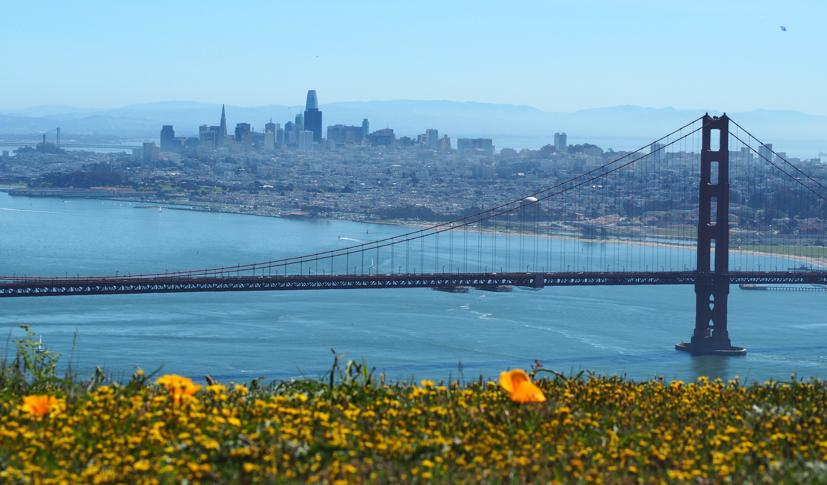

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp_hfaojq_.PNG'


In [93]:
# Query the collection
query_text = "In the city where the first internet cafe was started, what color are the flowers on a hill overlooking the bridge?"
query_embedding = model.encode(query_text).tolist()

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=1
)

# Display query results
formatted_texts =''
image  =0
for i, (doc, metadata_list) in enumerate(zip(results["documents"], results["metadatas"])):
    print(f"Result {i + 1}:")
    print(f"Text: {doc}")
    formatted_texts = "\n".join(doc)
    
    for metadata in metadata_list:
        # Decode and save the associated image if it exists
        if "image_data" in metadata:
            decoded_image_path = f"retrieved_image_{i + 1}.jpg"
            decode_image(metadata["image_data"], decoded_image_path)
            print(f"Image saved as: {decoded_image_path}")

            # image_data = base64.b64decode(metadata["image_data"])
            # image = Image.open(BytesIO(image_data))
            
            # Display the image
            image = Image.open(decoded_image_path)
            image.show()
            display(IPImage(decoded_image_path))
            
        else:
            print("No image associated with this result.")

In [81]:
sys_prompt = "You are an advanced assistant capable of analyzing both textual and visual data. You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively. You can assume that the image provided is that of the objects or people mentioned in the text. Try to give names as answer. Do not ask for clarifications, but give your best answer. Example question:  Supporting image: An image will be provided. Supporting Text: Color of Empire State Building is grey. Question: What is the color of the Empire State Building? Example answer: grey"
prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>" + sys_prompt + "<|eot_id|><|start_header_id|>user<|end_header_id|> <|image|> Supporting Text: " + formatted_texts + "Question: " + query_text + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

inputs = processor(image, prompt, return_tensors="pt").to(llm_model.device)
output = llm_model.generate(**inputs, max_new_tokens=35, temperature= 1.4,top_k= 15)
print(processor.decode(output[0]))

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `15` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpxd5fvrzk.PNG'


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>You are an advanced assistant capable of analyzing both textual and visual data. You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively. You can assume that the image provided is that of the objects or people mentioned in the text. Try to give names as answer. Do not ask for clarifications, but give your best answer. Example question:  Supporting image: An image will be provided. Supporting Text: Color of Empire State Building is grey. Question: What is the color of the Empire State Building? Example answer: grey<|eot_id|><|start_header_id|>user<|end_header_id|> <|image|> Supporting Text: The online café phenomenon in the United States was started in July 1991 by Wayne Gregori in San Francisco when he began SFnet Coffeehouse Network. Gregori designed, built and installed 25 coin-operated computer terminals in coff

In [94]:
sys_prompt = '''
You are an advanced AI model, whise task is to answer the question asked in the prompt concisely, in one to three words.
You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively.
Answer to the best of your ability, in a single go.
'''
prompt = f'''
<|begin_of_text|>\
<|start_header_id|>system<|end_header_id|>\
{sys_prompt}\
<|eot_id|>\
<|start_header_id|>user<|end_header_id|>\
<|image|> Supporting Text: {formatted_texts} \
Question: {query_text} \
<|eot_id|>\
<|start_header_id|>assistant<|end_header_id|>
'''

inputs = processor(image, prompt, return_tensors="pt").to(llm_model.device)
output = llm_model.generate(**inputs, max_new_tokens=35, temperature= 1.4,top_k= 15)
print(processor.decode(output[0]))

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `15` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


<|begin_of_text|>
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an advanced AI model, whise task is to answer the question asked in the prompt concisely, in one to three words.
You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively.
Answer to the best of your ability, in a single go.
<|eot_id|><|start_header_id|>user<|end_header_id|><|image|> Supporting Text: The online café phenomenon in the United States was started in July 1991 by Wayne Gregori in San Francisco when he began SFnet Coffeehouse Network. Gregori designed, built and installed 25 coin-operated computer terminals in coffeehouses throughout the San Francisco Bay Area. The café terminals dialed into a 32 line Bulletin Board System that offered an array of electronic services including FIDOnet mail and, in 1992, Internet mail. Question: In the city where the first internet cafe was started, what color are 

## RAG Example 3

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Result 1:
Text: ['Madrid (/məˈdrɪd/, Spanish:\xa0[maˈðɾið], locally\xa0[maˈðɾi(θ)]) is the capital of Spain and the largest municipality in both the Community of Madrid and Spain as a whole. The city has almost 3.166\xa0million inhabitants with a metropolitan area population of approximately 6.5 million. It is the third-largest city in the European Union (EU) after London and Berlin, and its metropolitan area is the third-largest in the EU after those of London and Paris. The municipality itself covers an area of 604.3\xa0km2 (233.3\xa0sq\xa0mi).']
Image saved as: retrieved_image_1.jpg


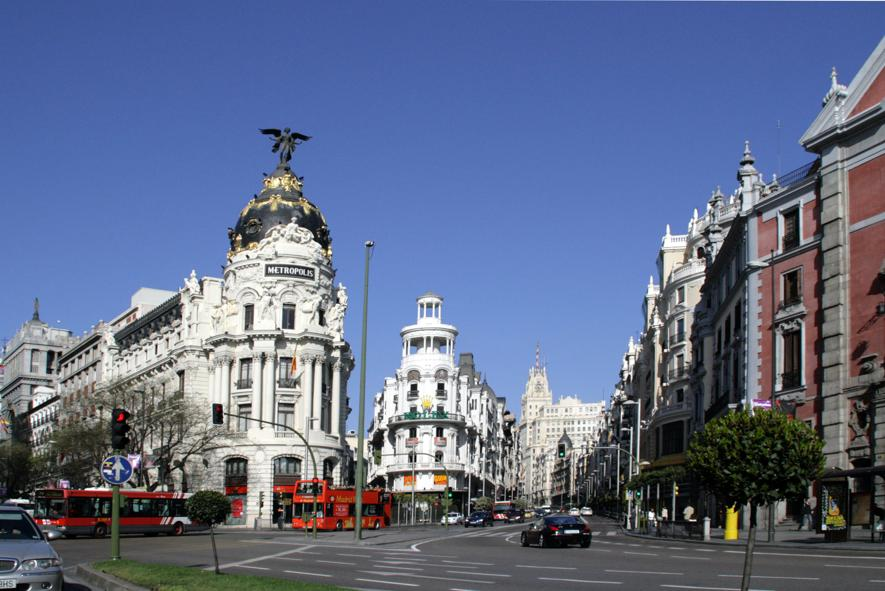

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp9i17fumg.PNG'


In [86]:
# Query the collection
query_text = "The city from the 1949-50 La Liga with a poster featuring a tall missile shaped tower with a round cap is the capital of what country?"
query_embedding = model.encode(query_text).tolist()

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=1
)

# Display query results
formatted_texts =''
image  =0
for i, (doc, metadata_list) in enumerate(zip(results["documents"], results["metadatas"])):
    print(f"Result {i + 1}:")
    print(f"Text: {doc}")
    formatted_texts = "\n".join(doc)
    
    for metadata in metadata_list:
        # Decode and save the associated image if it exists
        if "image_data" in metadata:
            decoded_image_path = f"retrieved_image_{i + 1}.jpg"
            decode_image(metadata["image_data"], decoded_image_path)
            print(f"Image saved as: {decoded_image_path}")

            # image_data = base64.b64decode(metadata["image_data"])
            # image = Image.open(BytesIO(image_data))
            
            # Display the image
            image = Image.open(decoded_image_path)
            image.show()
            display(IPImage(decoded_image_path))
            
        else:
            print("No image associated with this result.")

In [88]:
sys_prompt = "You are an advanced assistant capable of analyzing both textual and visual data. You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively. You can assume that the image provided is that of the objects or people mentioned in the text. Try to give names as answer. Do not ask for clarifications, but give your best answer. Example question:  Supporting image: An image will be provided. Supporting Text: Color of Empire State Building is grey. Question: What is the color of the Empire State Building? Example answer: grey"
prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>" + sys_prompt + "<|eot_id|><|start_header_id|>user<|end_header_id|> <|image|> Supporting Text: " + formatted_texts + "Question: " + query_text + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

inputs = processor(image, prompt, return_tensors="pt").to(llm_model.device)
output = llm_model.generate(**inputs, max_new_tokens=35, temperature= 1.4,top_k= 15)
print(processor.decode(output[0]))

<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>You are an advanced assistant capable of analyzing both textual and visual data. You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively. You can assume that the image provided is that of the objects or people mentioned in the text. Try to give names as answer. Do not ask for clarifications, but give your best answer. Example question:  Supporting image: An image will be provided. Supporting Text: Color of Empire State Building is grey. Question: What is the color of the Empire State Building? Example answer: grey<|eot_id|><|start_header_id|>user<|end_header_id|> <|image|> Supporting Text: Madrid (/məˈdrɪd/, Spanish: [maˈðɾið], locally [maˈðɾi(θ)]) is the capital of Spain and the largest municipality in both the Community of Madrid and Spain as a whole. The city has almost 3.166 million inhabitants with a metropoli

In [89]:
sys_prompt = '''
You are an advanced AI model, whise task is to answer the question asked in the prompt concisely, in one to three words.
You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively.
Answer to the best of your ability, in a single go.
'''
prompt = f'''
<|begin_of_text|>\
<|start_header_id|>system<|end_header_id|>\
{sys_prompt}\
<|eot_id|>\
<|start_header_id|>user<|end_header_id|>\
<|image|> Supporting Text: {formatted_texts} \
Question: {query_text} \
<|eot_id|>\
<|start_header_id|>assistant<|end_header_id|>
'''

inputs = processor(image, prompt, return_tensors="pt").to(llm_model.device)
output = llm_model.generate(**inputs, max_new_tokens=35, temperature= 1.4,top_k= 15)
print(processor.decode(output[0]))

<|begin_of_text|>
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an advanced AI model, whise task is to answer the question asked in the prompt concisely, in one to three words.
You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively.
Answer to the best of your ability, in a single go.
<|eot_id|><|start_header_id|>user<|end_header_id|><|image|> Supporting Text: Madrid (/məˈdrɪd/, Spanish: [maˈðɾið], locally [maˈðɾi(θ)]) is the capital of Spain and the largest municipality in both the Community of Madrid and Spain as a whole. The city has almost 3.166 million inhabitants with a metropolitan area population of approximately 6.5 million. It is the third-largest city in the European Union (EU) after London and Berlin, and its metropolitan area is the third-largest in the EU after those of London and Paris. The municipality itself covers an area of 604.3 km2 (233.3 sq mi). 

## RAG: Example-4

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Result 1:
Text: ['Manchester City are the defending champions. Wolverhampton Wanderers, Cardiff City and Fulham join as the promoted clubs from the 2017–18 EFL Championship. They will replace West Bromwich Albion, Swansea City and Stoke City who were relegated to the 2018–19 EFL Championship. Manchester City are the defending champions. Wolverhampton Wanderers, Cardiff City and Fulham join as the promoted clubs from the 2017–18 EFL Championship. They will replace West Bromwich Albion, Swansea City and Stoke City who were relegated to the 2018–19 EFL Championship. Manchester City are the defending champions. Wolverhampton Wanderers, Cardiff City and Fulham join as the promoted clubs from the 2017–18 EFL Championship. They will replace West Bromwich Albion, Swansea City and Stoke City who were relegated to the 2018–19 EFL Championship.']
Image saved as: retrieved_image_1.jpg


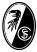

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpc4j82is3.PNG'


In [98]:
# Query the collection
query_text = "Which team that played Barnsley F.C in the 1999-2000 season finals has a lower pos:  The team with a logo featuring a rose with attached leaves or the team who got relegated from the premier league in 2018?"
query_embedding = model.encode(query_text).tolist()

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=1
)

# Display query results
formatted_texts =''
image  =0
for i, (doc, metadata_list) in enumerate(zip(results["documents"], results["metadatas"])):
    print(f"Result {i + 1}:")
    print(f"Text: {doc}")
    formatted_texts = "\n".join(doc)
    
    for metadata in metadata_list:
        # Decode and save the associated image if it exists
        if "image_data" in metadata:
            decoded_image_path = f"retrieved_image_{i + 1}.jpg"
            decode_image(metadata["image_data"], decoded_image_path)
            print(f"Image saved as: {decoded_image_path}")

            # image_data = base64.b64decode(metadata["image_data"])
            # image = Image.open(BytesIO(image_data))
            
            # Display the image
            image = Image.open(decoded_image_path)
            image.show()
            display(IPImage(decoded_image_path))
            
        else:
            print("No image associated with this result.")

In [85]:
sys_prompt = "You are an advanced assistant capable of analyzing both textual and visual data. You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively. You can assume that the image provided is that of the objects or people mentioned in the text. Try to give names as answer. Do not ask for clarifications, but give your best answer. Example question:  Supporting image: An image will be provided. Supporting Text: Color of Empire State Building is grey. Question: What is the color of the Empire State Building? Example answer: grey"
prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>" + sys_prompt + "<|eot_id|><|start_header_id|>user<|end_header_id|> <|image|> Supporting Text: " + formatted_texts + "Question: " + query_text + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

inputs = processor(image, prompt, return_tensors="pt").to(llm_model.device)
output = llm_model.generate(**inputs, max_new_tokens=35, temperature= 1.4,top_k= 15)
print(processor.decode(output[0]))

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `15` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpu533qzin.PNG'


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>You are an advanced assistant capable of analyzing both textual and visual data. You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively. You can assume that the image provided is that of the objects or people mentioned in the text. Try to give names as answer. Do not ask for clarifications, but give your best answer. Example question:  Supporting image: An image will be provided. Supporting Text: Color of Empire State Building is grey. Question: What is the color of the Empire State Building? Example answer: grey<|eot_id|><|start_header_id|>user<|end_header_id|> <|image|> Supporting Text: Manchester City are the defending champions. Wolverhampton Wanderers, Cardiff City and Fulham join as the promoted clubs from the 2017–18 EFL Championship. They will replace West Bromwich Albion, Swansea City and Stoke City who w

In [100]:
sys_prompt = '''
You are an advanced AI model, whise task is to answer the question asked in the prompt concisely, in one to three words.
You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively.
Answer to the best of your ability, in a single word, in a single go.
'''
prompt = f'''
<|begin_of_text|>\
<|start_header_id|>system<|end_header_id|>\
{sys_prompt}\
<|eot_id|>\
<|start_header_id|>user<|end_header_id|>\
<|image|> Supporting Text: {formatted_texts} \
Question: {query_text} \
<|eot_id|>\
<|start_header_id|>assistant<|end_header_id|>
'''

inputs = processor(image, prompt, return_tensors="pt").to(llm_model.device)
output = llm_model.generate(**inputs, max_new_tokens=35, temperature= 1.4,top_k= 15)
print(processor.decode(output[0]))

<|begin_of_text|>
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an advanced AI model, whise task is to answer the question asked in the prompt concisely, in one to three words.
You use the provided text and image to answer the user's question accurately in one word. You integrate insights from both the text and image effectively.
Answer to the best of your ability, in a single word, in a single go.
<|eot_id|><|start_header_id|>user<|end_header_id|><|image|> Supporting Text: Manchester City are the defending champions. Wolverhampton Wanderers, Cardiff City and Fulham join as the promoted clubs from the 2017–18 EFL Championship. They will replace West Bromwich Albion, Swansea City and Stoke City who were relegated to the 2018–19 EFL Championship. Manchester City are the defending champions. Wolverhampton Wanderers, Cardiff City and Fulham join as the promoted clubs from the 2017–18 EFL Championship. They will replace West Bromwich Albion, Swansea City and Stoke City